In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# Path to ZIP
zip_path = '/content/drive/MyDrive/archive.zip'
# Path to extracted file
extract_path = '/content/drive/MyDrive'
# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted!")

Dataset extracted!


In [3]:
# Path to dataset
data_dir = '/content/drive/MyDrive/combined_images'
total_images = 0
for root, dirs, files in os.walk(data_dir):
    total_images += len(files)

print(f"Total images in dataset: {total_images}")

Total images in dataset: 44000


In [4]:
from collections import Counter

class_distribution = Counter()
for root, dirs, files in os.walk(data_dir):
    for file in files:
        class_label = os.path.basename(root)
        class_distribution[class_label] += 1

print(f"Class distribution: {class_distribution}")

Class distribution: Counter({'NonDemented': 12800, 'VeryMildDemented': 11200, 'MildDemented': 10000, 'ModerateDemented': 10000})


In [5]:
# Create dummy corrupt images
for i in range(3):
    corrupt_file_path = os.path.join(data_dir, f"corrupt_dummy_{i}.jpg")
    with open(corrupt_file_path, 'w') as f:
        f.write('This is not a valid image file')

print("Dummy corrupt images created!")

Dummy corrupt images created!


In [6]:
from PIL import Image

# List to store corrupt file paths
corrupt_images = []

# Walk through all files
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify image is not broken
        except (IOError, SyntaxError) as e:
            print(f"❌ Corrupt image detected: {file_path}")
            corrupt_images.append(file_path)

print(f"\n Total corrupt images found: {len(corrupt_images)}")

❌ Corrupt image detected: /content/drive/MyDrive/combined_images/corrupt_dummy_0.jpg
❌ Corrupt image detected: /content/drive/MyDrive/combined_images/corrupt_dummy_1.jpg
❌ Corrupt image detected: /content/drive/MyDrive/combined_images/corrupt_dummy_2.jpg

 Total corrupt images found: 3


In [7]:
for img_path in corrupt_images:
    os.remove(img_path)

print("All corrupt images deleted!")

All corrupt images deleted!


In [ ]:
from tensorflow.keras import Sequential, layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Image Size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 70% Training, 15% Validation, 15% Testing
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names before applying map
class_names = train_ds.class_names  # Store class_names here

# Splitting val_test_ds into Validation and Test
val_batches = int(0.5 * val_test_ds.cardinality().numpy())

val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

# Normalize pixel values (0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 44000 files belonging to 4 classes.
Using 30800 files for training.
Found 44000 files belonging to 4 classes.
Using 13200 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

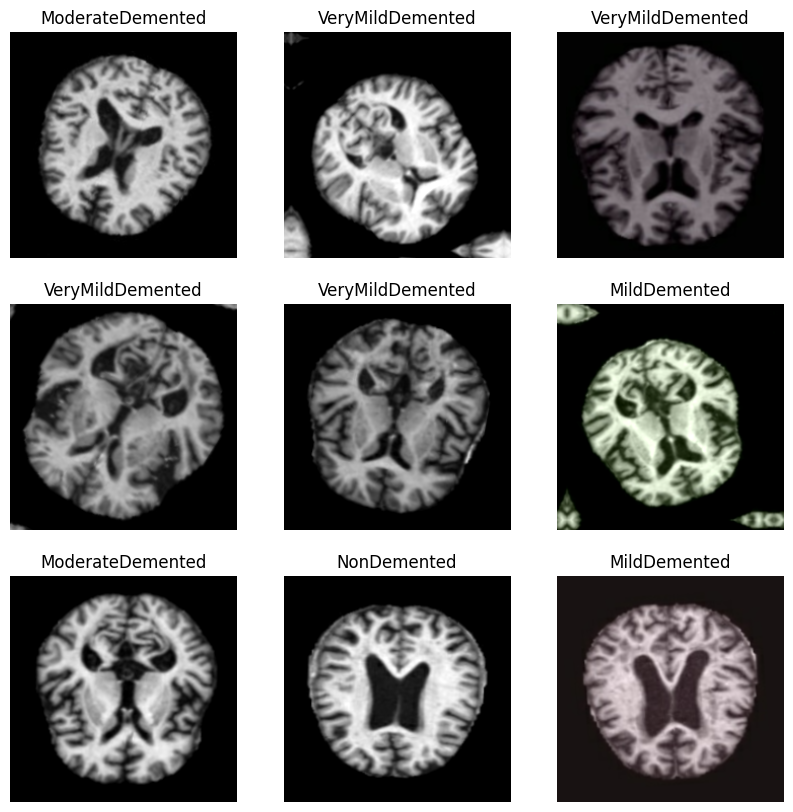

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):
        augmented_image = data_augmentation(images[i])

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Define data_augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])

# Baseline model
baseline_model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    Dense(4, activation='softmax')  # 4 classes
])

# Apply data augmentation to the training dataset (train_ds)
def augment_data(image, label):
    augmented_image = data_augmentation(image)
    return augmented_image, label

train_ds = train_ds.map(augment_data)

baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,948,900 (49.40 MB)

 Trainable params: 12,948,900 (49.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # stop after 5 epochs without improvement
    restore_best_weights=True # restores the best model instead of the last epoch
)

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 581s 594ms/step - accuracy: 0.3927 - loss: 1.2484 - val_accuracy: 0.5915 - val_loss: 0.8654
Epoch 2/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 479s 497ms/step - accuracy: 0.5968 - loss: 0.8586 - val_accuracy: 0.6540 - val_loss: 0.7055
Epoch 3/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 480s 497ms/step - accuracy: 0.6407 - loss: 0.7550 - val_accuracy: 0.6723 - val_loss: 0.6878
Epoch 4/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 515s 511ms/step - accuracy: 0.6698 - loss: 0.7031 - val_accuracy: 0.7089 - val_loss: 0.6292
Epoch 5/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 474s 482ms/step - accuracy: 0.6835 - loss: 0.6668 - val_accuracy: 0.7418 - val_loss: 0.5772
Epoch 6/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 466s 484ms/step - accuracy: 0.7101 - loss: 0.6306 - val_accuracy: 0.7541 - val_loss: 0.5428
Epoch 7/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 466s 483ms/step - accuracy: 0.7288 - loss: 0.5956 - val_accuracy: 0.7612 - val_loss: 0.5310
Epoch 8/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 501s 482ms/step - accuracy: 0.7366 -

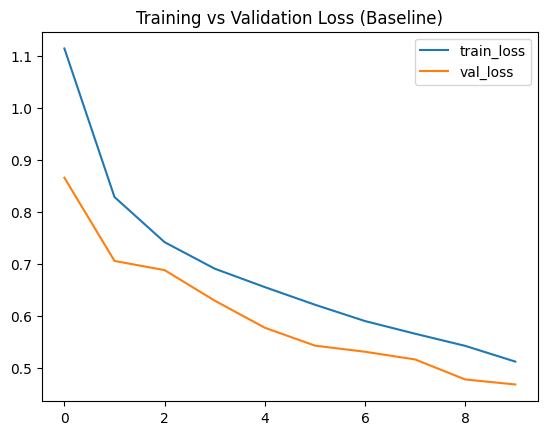

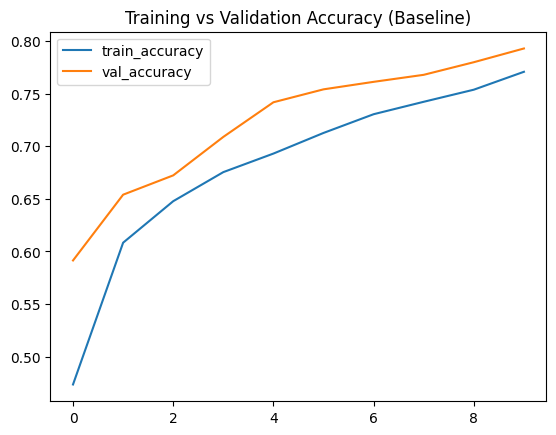

In [ ]:
# Plot loss
plt.plot(history_baseline.history['loss'], label='train_loss')
plt.plot(history_baseline.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training vs Validation Loss (Baseline)')
plt.show()

# Plot accuracy
plt.plot(history_baseline.history['accuracy'], label='train_accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy (Baseline)')
plt.show()

In [ ]:
loss, accuracy = baseline_model.evaluate(test_ds)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.7982 - loss: 0.4665
Test Loss: 0.4554
Test Accuracy: 0.7993


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = baseline_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
# Load ResNet50 without the top (classification) layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Feature extraction first!

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
from tensorflow.keras.layers import BatchNormalization
# Build your custom model on top of ResNet50
transfer_model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,  # Apply augmentation
    layers.Lambda(tf.keras.applications.resnet50.preprocess_input),  # Then preprocess
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

transfer_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,308 (91.99 MB)

 Trainable params: 526,084 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [ ]:
transfer_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/4
963/963 ━━━━━━━━━━━━━━━━━━━━ 515s 524ms/step - accuracy: 0.3858 - loss: 1.3565 - val_accuracy: 0.4556 - val_loss: 1.4642 - learning_rate: 0.0010
Epoch 2/4
963/963 ━━━━━━━━━━━━━━━━━━━━ 512s 530ms/step - accuracy: 0.4629 - loss: 1.1793 - val_accuracy: 0.2940 - val_loss: 2.4842 - learning_rate: 0.0010
Epoch 3/4
963/963 ━━━━━━━━━━━━━━━━━━━━ 555s 523ms/step - accuracy: 0.4757 - loss: 1.1538 - val_accuracy: 0.2972 - val_loss: 2.1879 - learning_rate: 0.0010
Epoch 4/4
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4877 - loss: 1.1397
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
963/963 ━━━━━━━━━━━━━━━━━━━━ 561s 522ms/step - accuracy: 0.4877 - loss: 1.1397 - val_accuracy: 0.2987 - val_loss: 2.7214 - learning_rate: 0.0010


In [ ]:
# Unfreeze some of the base model layers
base_model.trainable = True

# Fine-tune from layer 50 onwards
fine_tune_at = 50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile with a lower learning rate for fine-tuning
transfer_model.compile(
    tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),  # Lower LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning training
fine_tune_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 574s 573ms/step - accuracy: 0.5078 - loss: 1.1481 - val_accuracy: 0.6514 - val_loss: 0.7904 - learning_rate: 0.0010
Epoch 2/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 575s 597ms/step - accuracy: 0.6869 - loss: 0.6860 - val_accuracy: 0.6635 - val_loss: 0.7344 - learning_rate: 0.0010
Epoch 3/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 619s 594ms/step - accuracy: 0.7393 - loss: 0.5848 - val_accuracy: 0.8035 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 4/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 556s 576ms/step - accuracy: 0.7804 - loss: 0.5026 - val_accuracy: 0.8486 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 5/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 567s 581ms/step - accuracy: 0.8207 - loss: 0.4239 - val_accuracy: 0.8709 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 6/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 571s 592ms/step - accuracy: 0.8499 - loss: 0.3589 - val_accuracy: 0.9129 - val_loss: 0.2152 - learning_rate: 0.0010
Epoch 7/10
963/963 ━━━━━━━━━━━━━━━━━━━━ 555s 576ms/step - accura

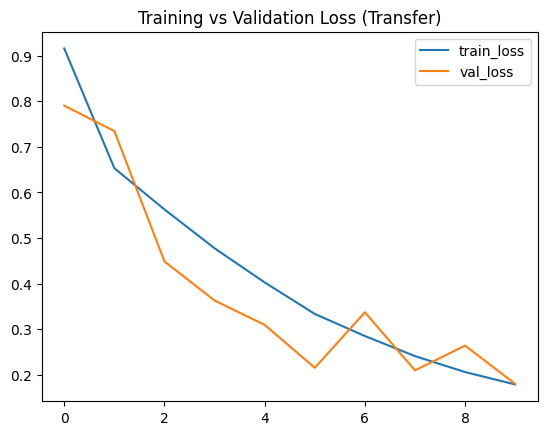

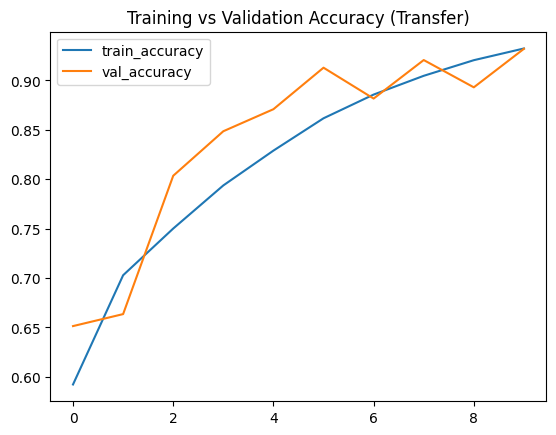

In [ ]:
# Plot loss
plt.plot(fine_tune_history.history['loss'], label='train_loss')
plt.plot(fine_tune_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training vs Validation Loss (Transfer)')
plt.show()

# Plot accuracy
plt.plot(fine_tune_history.history['accuracy'], label='train_accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy (Transfer)')
plt.show()

In [ ]:
test_loss, test_acc = transfer_model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - accuracy: 0.9330 - loss: 0.1808
Validation Accuracy: 79.93%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

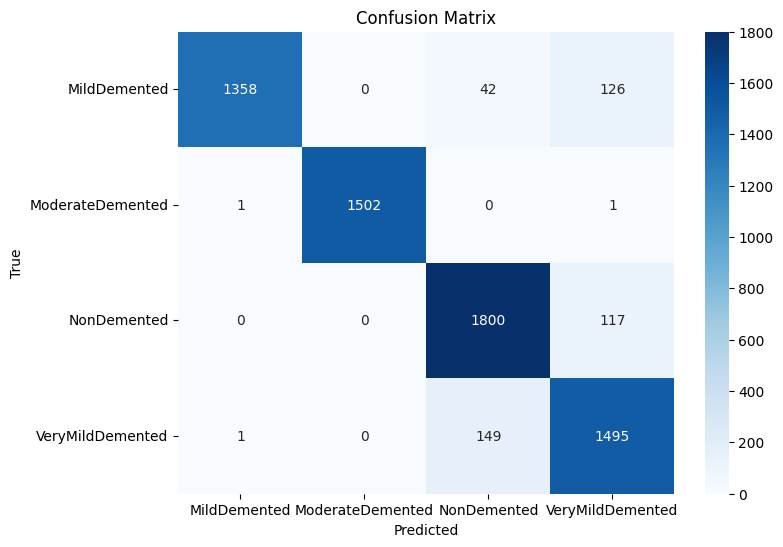

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = transfer_model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

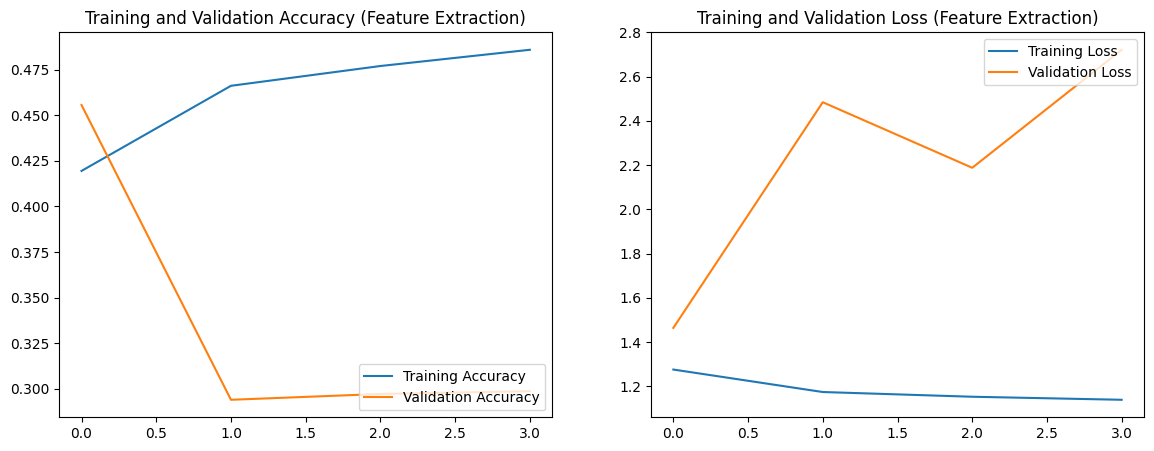

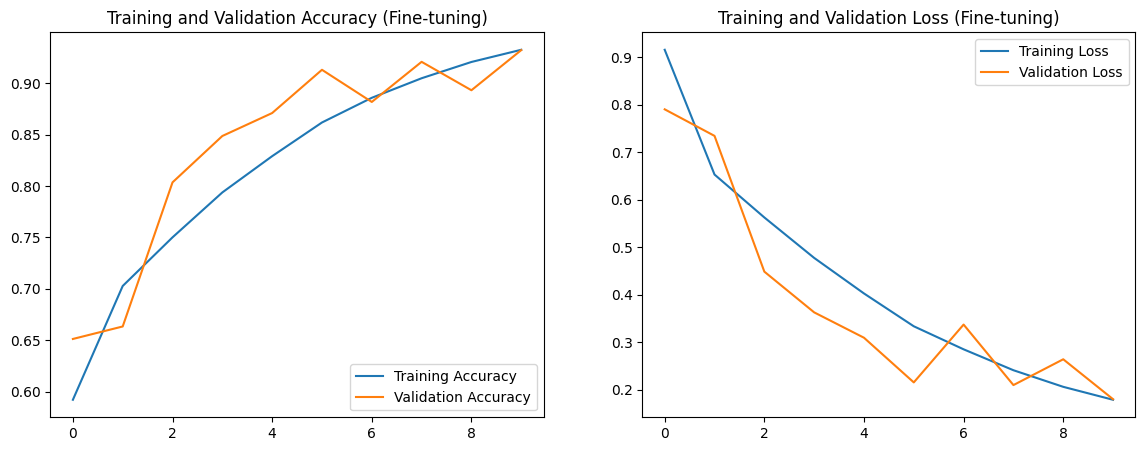

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_training_history(history, title_suffix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy {title_suffix}')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss {title_suffix}')

    plt.show()

# Plot for Feature Extraction
plot_training_history(history, title_suffix="(Feature Extraction)")

# Plot for Fine-tuning
plot_training_history(fine_tune_history, title_suffix="(Fine-tuning)")